# Multi-output Gaussian Processes for Dose Response Predictions
## In this notebook:
1. We train a MOGP model using the GDSC1 dataset and compute a features ranking by means of the KL-Relevance determination method.
2. We train the MOGP model using the GDSC2 dataset and compute a features ranking via KL-Relevance method.
3. We generate a figure to compare both KL-Relevance rankings obtained with the MOGP models trained on GDSC1 and GDSC2. 

## Experiments for GDSC1 Dataset

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import MinMaxScaler
import os
import matplotlib.pyplot as plt

plt.close('all')

_FOLDER = "./Dataset_BRAF_NoReplica_ANOVA_Features/GDSC1/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys
sys.path.append('..')

warnings.filterwarnings("ignore")
"Best Model Drug1061: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 1.0000 -k 2 -w 1.0000 -r 1014 -p 505 -d 1061 -e 0"
"Best Model Drug1373: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 1.0000 -k 2 -w 1.0000 -r 1013 -p 221 -d 1373 -e 0"
"Best Model Drug1036: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1018 -p 946 -d 1036 -e 0"

'Best Model Drug1036: ExactMOGP_and_KLRelevance_MelanomaGDSC1_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1018 -p 946 -d 1036 -e 0'

In [2]:
class commandLine:
    def __init__(self):
        "TODO: check that Niter is actually used!!!!"
        self.N_iter = 30    #number of iterations
        self.which_seed = 1018    #change seed to initialise the hyper-parameters
        self.rank = 2
        self.scale = 1.0
        self.weight = 0.01
        self.bash = "946"
        self.drug_name = "1036"
        self.Train = False   #Switch to False if just want the load the already trained model
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

''

In [3]:
"#Bear in mind that the drugs 1061 and 1036 have 9 concentrations, i.e., d1, d2, d3, d4, d5, d6, d7, d8 and d9 "
"#but the drugs 1371 and 1373 have 5 concentrations, i.e, d1, d3, d5, d7 and d9"
"#Drugs 1036 and 1371 are the same one, but the former has 9 concentrations and the latter 5 concentrations"

dconcentr = {"1061": "9conc","1036": "9conc","1373": "5conc","1371": "5conc"}
feat_for_drug = {"1061": "2-fold","1036": "2-fold","1373": "4-fold","1371": "4-fold"}
name_for_KLrelevance = 'GDSC1_melanoma_BRAF_'+dconcentr[config.drug_name]+'_noreps_v3.csv'
name_ANOVA_feat_file = 'GDSC1_BRAFmelanoma_ANOVAfeatures_'+feat_for_drug[config.drug_name]+'.csv'

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
df_ANOVA_feat_Names = pd.read_csv(_FOLDER + name_ANOVA_feat_file)  # Contain Feature Names used by ANOVA
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_No_MolecForm = df_train_No_MolecForm[(df_train_No_MolecForm["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

# the column index 29 for Drug 1061 the input features start
# but column index 21 is for Drug 1373
if config.drug_name == "1061" or config.drug_name == "1036":
    Dnorm_cell = 9
    start_pos_features = 29
elif config.drug_name == "1373" or config.drug_name == "1371":
    Dnorm_cell = 5
    start_pos_features = 21

print(df_train_No_MolecForm.columns[start_pos_features])

ARID1A_mut


In [4]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Scale the Genomic features to be between 0 and 1"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we extract from the dataframe the D outputs related to each dose concentration"
"Below we select 9 concentration since GDSC1 has that number for Drugs 1036 and 1061"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, Dnorm_cell+1):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)

(40, 1)
Ytrain size:  (40, 9)


In [5]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Since we fitted the dose response curves with a Sigmoid4_parameters function"
"We extract the optimal coefficients in order to reproduce such a Sigmoid4_parameters fitting"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):  #here there are four params for sigmoid4
    params_4_sig_train = np.concatenate(
        (params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)


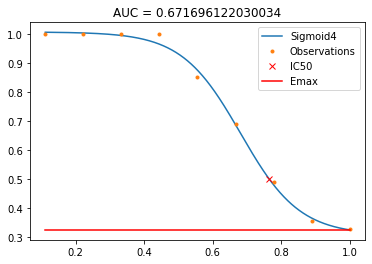

In [6]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this sections we will extract the summary metrics AUC, Emax and IC50 from the Sigmoid4_parameters functions"
"These metrics are used as the references to compute the error metrics"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn import metrics
from importlib import reload
import Utils_SummaryMetrics_KLRelevance
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)

"Be careful that x starts from 0.111111 for 9 or 5 drug concentrations in GDSC1 dataset"
"but x starts from 0.142857143 for the case of 7 drug concentrations in GDSC2 dataset"
"The function Get_IC50_AUC_Emax is implemented in Utils_SummaryMetrics_KLRelevance.py to extract the summary metrics"
x_lin = np.linspace(0.111111, 1, 1000)
x_real_dose = np.linspace(0.111111, 1, Dnorm_cell)  #Here is Dnorm_cell due to using GDSC1 that has 9 or 5 doses
Ydose50,Ydose_res,IC50,AUC,Emax = MyUtils.Get_IC50_AUC_Emax(params_4_sig_train,x_lin,x_real_dose)

def my_plot(posy,fig_num,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug):
    plt.figure(fig_num)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    plt.legend(['Sigmoid4','Observations','IC50','Emax'])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we can visualise the values of the GDSC1 dataset with the fitting of Sigmoid4_parameters function"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
posy = 10   #select the location you want to plot, do not exceed the Ytrain length
my_plot(posy,0,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug)

In [7]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Organize summary metrics with proper dimensionality"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
Name_Features_Melanoma = df_train_No_MolecForm.columns[start_pos_features:]
Xall = X_train_features.copy()
Yall = y_train_drug.copy()

print("Sanity check to the same features Evelyin Provided")
print(df_ANOVA_feat_Names["feature"].values[start_pos_features:]==Name_Features_Melanoma)

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

Sanity check to the same features Evelyin Provided
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AUC train size: (40, 1)
IC50 train size: (40, 1)
Emax train size: (40, 1)
X all data size: (40, 24)
Y all data size: (40, 9)


In [8]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn.model_selection import KFold, cross_val_score
Ndata = Xall.shape[0]
Xind = np.arange(Ndata)
nsplits = 20 #Ndata
k_fold = KFold(n_splits=nsplits)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell

In [9]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"MOGP model Training process"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell
list_folds = list(k_fold.split(Xall))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The for loop below runs the cross-validation process for the MOGP model"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
for Nfold in range(0,nsplits+1):
    model = []
    "The first if below is for the cross-val"
    "Then the else is for using all data to save the model trained over all data"
    Xtrain,Ytrain,Xval,Xval_aux,Yval,Emax_val,IC50_val,AUC_val=MyUtils.ArrangeData_to_CrossVal(Ntasks,Nfold,nsplits,list_folds,Xall,Yall,Emax_all,IC50_all,AUC_all)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import GPy
    # os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean_all = np.zeros_like(Yval)
    models_outs = []

    rank = int(config.rank)  # Rank for the MultitaskKernel
    "Below we substract one due to being the label associated to the output"
    Dim = Xtrain.shape[1]-1
    myseed = int(config.which_seed)
    np.random.seed(myseed)
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Product Kernels. Below we use the locations:"
    "Kernel1 accounts for locations 0:11 for Mutation"
    "Kernel2 accounts for locations 11:end for PANCAN"
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    split_dim = 2
    AddKern_loc = [11, Dim]
    mykern = GPy.kern.RBF(AddKern_loc[0], active_dims=list(np.arange(0, AddKern_loc[0])))
    print(list(np.arange(0, AddKern_loc[0])))
    for i in range(1, split_dim):
        mykern = mykern * GPy.kern.RBF(AddKern_loc[i]-AddKern_loc[i-1],active_dims=list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))
        print(list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the kernel hyper-parameters"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    mykern.rbf.lengthscale = float(config.scale)* np.sqrt(Dim) * np.random.rand()
    mykern.rbf.variance.fix()
    for i in range(1,split_dim):
        eval("mykern.rbf_"+str(i)+".lengthscale.setfield(float(config.scale)* np.sqrt(Dim) * np.random.rand(), np.float64)")
        eval("mykern.rbf_" + str(i) + ".variance.fix()")

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Create the coregionalization kernel for the MOGP model and create the MOGPRegression model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    kern = mykern ** GPy.kern.Coregionalize(1, output_dim=Ntasks,rank=rank)
    model = GPy.models.GPRegression(Xtrain, Ytrain, kern)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the linear combination coefficients for coregionalization matrix of MOGP"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Init_Ws = float(config.weight) * np.random.randn(Ntasks,rank)
    model.kern.coregion.W = Init_Ws
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "If config.Train is True we will train the models for all Kfold to estimate performance of the seed"
    "On the contrary, if config.Train is False we do not train but load the already best Trained model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    if config.Train:
        #model.optimize(optimizer='lbfgsb',messages=True,max_iters=int(config.N_iter))
        model.optimize()
    else:
        # Here we load the model bash*:
        m_trained = str(config.bash)
        print("loading model ", m_trained)
        model[:] = np.load('./GDSC1_Codes_ANOVAFeatures/Best_Model_Drug' + config.drug_name + '_MelanomaGDSC1_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Make predictions for the Kfold-out"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    m_pred, v_pred = model.predict(Xval, full_cov=False)
    Yval_curve = Yval.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    m_pred_curve = m_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    v_pred_curve = v_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Here we extract the summary metrics AUC, Emax and IC50 from the MOGP curve predictions"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    x_dose = np.linspace(0.111111, 1.0, Ntasks)
    x_dose_new = np.linspace(0.111111, 1.0, 1000)  #This new lispace is for the pchip interpolation
    Y_pred_interp_all,std_upper_interp_all,std_lower_interp_all,_, Ydose50_pred, IC50_pred, AUC_pred, Emax_pred = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose =x_dose,x_dose_new = x_dose_new,m_pred_curve=m_pred_curve, v_pred=v_pred)

    Ydose50_pred = np.array(Ydose50_pred)
    IC50_pred = np.array(IC50_pred)[:,None]
    AUC_pred = np.array(AUC_pred)[:, None]
    Emax_pred = np.array(Emax_pred)[:, None]
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Compute different error metrics!"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_NMLL = -np.mean(model.log_predictive_density(Xval, Yval))  #Negative Log Predictive Density (NLPD)
    Emax_abs = np.mean(np.abs(Emax_val - Emax_pred))
    AUC_abs = np.mean(np.abs(AUC_val - AUC_pred))
    IC50_MSE = np.mean((IC50_val - IC50_pred) ** 2)
    MSE_curves = np.mean((m_pred_curve - Yval_curve) ** 2, 1)
    AllPred_MSE = np.mean((m_pred_curve - Yval_curve) ** 2)

    Med_MSE = np.median(MSE_curves)
    Mean_MSE = np.mean(MSE_curves)

    if Nfold < nsplits:
        print(f'\nError Metrics fold {Nfold}:')
        print("\nNegLPD Val", Val_NMLL)
        print("IC50 MSE:", IC50_MSE)
        print("AUC MAE:", AUC_abs)
        print("Emax MAE:", Emax_abs)
        print("Med_MSE:", Med_MSE)
        print("Mean_MSE:", Mean_MSE)
        print("All Predictions MSE:", AllPred_MSE)

        NegMLL_AllFolds.append(Val_NMLL.copy())
        Emax_abs_AllFolds.append(Emax_abs.copy())
        AUC_abs_AllFolds.append(AUC_abs.copy())
        IC50_MSE_AllFolds.append(IC50_MSE.copy())
        Med_MSE_AllFolds.append(Med_MSE.copy())
        Mean_MSE_AllFolds.append(Mean_MSE.copy())
        AllPred_MSE_AllFolds.append(AllPred_MSE.copy())

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

[0 1] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 0:

NegLPD Val 0.4508376841579971
IC50 MSE: 0.6078293579329678
AUC MAE: 0.19607374118774165
Emax MAE: 0.16059862000022734
Med_MSE: 0.0723794975896675
Mean_MSE: 0.0723794975896675
All Predictions MSE: 0.0723794975896675
[2 3] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 1:

NegLPD Val 1.0628466794889202
IC50 MSE: 0.7359042462949372
AUC MAE: 0.4108794265888157
Emax MAE: 0.5150502374300431
Med_MSE: 0.32506275074416635
Mean_MSE: 0.32506275074416635
All Predictions MSE: 0.32506275074416635
[4 5] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  946

Error Metrics fold 2:

NegLPD Val -0.22477334352346773
IC50 MSE: 0.1908787632639253
AUC MAE: 0.0895706649101686
Emax MAE: 0.234665204749

In [10]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Cross validation performance of the current seed"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print('Metrics of Seed performance along K-folds (mean +/- std):\n')
print(f'dose response curve MSE: {np.mean(AllPred_MSE_AllFolds)} +/- {np.std(AllPred_MSE_AllFolds)}')
print(f'NegLog Predictive Density: {np.mean(NegMLL_AllFolds)} +/- {np.std(NegMLL_AllFolds)}')
print(f'IC50 MSE: {np.mean(IC50_MSE_AllFolds)} +/- {np.std(IC50_MSE_AllFolds)}')
print(f'AUC MAE: {np.mean(AUC_abs_AllFolds)} +/- {np.std(AUC_abs_AllFolds)}')
print(f'Emax MAE: {np.mean(Emax_abs_AllFolds)} +/- {np.std(Emax_abs_AllFolds)}')

Metrics of Seed performance along K-folds (mean +/- std):

dose response curve MSE: 0.09890452302286187 +/- 0.10212468855804228
NegLog Predictive Density: 0.1702506861092739 +/- 0.7642101297150027
IC50 MSE: 0.32785337163389927 +/- 0.30482092447514886
AUC MAE: 0.19411497851573462 +/- 0.12222080463413161
Emax MAE: 0.25474276565271287 +/- 0.17267962741933504


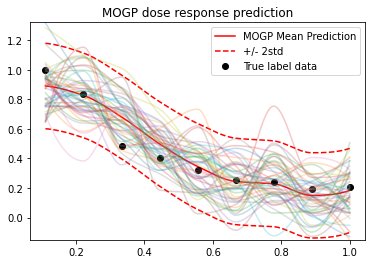

In [11]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Make predictions with the model and plot one of the dose response curves"
"We plot the mean +/- 2std of the MOGP predicitons"
"The multiple coloured functions are samples from predictive posterior distribution"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
N_Samples = 50
Ypred_interp,StdPred_upper_interp,StdPred_lower_interp,Ypred_MOGP_Samples,_,_,_,_ = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose,x_dose_new = x_dose_new,model=model,Xval=Xtrain,MOGPsamples=N_Samples)

idx = 0
#for idx in range(20):
plt.figure(idx)
plt.ylim([-0.15,1.32])
plt.plot(x_dose_new,Ypred_interp[idx],'r')
plt.plot(x_dose_new,StdPred_upper_interp[idx],'r--')
plt.plot(x_dose_new,StdPred_lower_interp[idx],'r--')
plt.plot(x_dose, Yall[idx], 'ko')
plt.title('MOGP dose response prediction')
plt.legend(["MOGP Mean Prediction","+/- 2std","_nolegend","True label data"])
for i in range(N_Samples):
    plt.plot(x_dose_new, Ypred_MOGP_Samples[idx][i],alpha=0.25)


In [12]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here We run the KLRelevance algorith over an specific p-th feature"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from importlib import reload
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)
KLRel = np.zeros((Xtrain.shape[0]//Dnorm_cell,Xtrain.shape[1]-1))
FileName = "Drug"+config.drug_name+"_MelanomaGDSC1_ANOVA_ExactMOGP_m"+m_trained
for pth_feat in range(24):
    relevance = MyUtils.KLRelevance_MOGP_GPy(train_x=Xtrain, model=model, delta=1.0e-6,
                                                       which_p=int(pth_feat), diag=False, Use_Cholesky=True,
                                                       ToSave=False, FileName=FileName)
    KLRel[:,pth_feat] = relevance[:,pth_feat].copy()

Mean_KLRel = np.mean(KLRel,0)[None,:]
Norm_Mean_KLRel = Mean_KLRel/np.max(Mean_KLRel)
Norm_Mean_KLRel_sorted = np.sort(Norm_Mean_KLRel).flatten()[::-1]
ind_sort = np.argsort(Norm_Mean_KLRel)
Names_features_sorted = Name_Features_Melanoma[ind_sort].flatten()[::-1]

Analysing Feature 0 of 24...
Analysing Feature 1 of 24...
Analysing Feature 2 of 24...
Analysing Feature 3 of 24...
Analysing Feature 4 of 24...
Analysing Feature 5 of 24...
Analysing Feature 6 of 24...
Analysing Feature 7 of 24...
Analysing Feature 8 of 24...
Analysing Feature 9 of 24...
Analysing Feature 10 of 24...
Analysing Feature 11 of 24...
Analysing Feature 12 of 24...
Analysing Feature 13 of 24...
Analysing Feature 14 of 24...
Analysing Feature 15 of 24...
Analysing Feature 16 of 24...
Analysing Feature 17 of 24...
Analysing Feature 18 of 24...
Analysing Feature 19 of 24...
Analysing Feature 20 of 24...
Analysing Feature 21 of 24...
Analysing Feature 22 of 24...
Analysing Feature 23 of 24...


In [13]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we just update the names of the genomic features and actual drug names"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_new_names={"BRAF_mut":'BRAF mut',
                "ARID1A_mut":"ARID1A mut",
                "EZH2_mut":"EZH2 mut",
                "MECOM_mut":"MECOM mut",
                "PLCB1_mut":"PLCB1 mut",
                "PTEN_mut":"PTEN mut",
                "NRAS_mut":"NRAS mut",
                "ARID2_mut":"ARID2 mut",
                "TP53_mut":"TP53 mut",
                "NF1_mut":"NF1 mut",
                "CDKN2A_mut":"CDKN2A mut",
                "loss.cnaSKCM3":"loss.cna.chr16q23.1",
                "loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.":"loss.cna.chr9p24.3",
                "loss.cnaSKCM5..PAX5.":"loss.cna.chr9p13.2",
                "loss.cnaSKCM9":"loss.cna.chr17p13.2",
                "gain.cnaSKCM12..KRAS.":"gain.cna.chr12p12.3",
                "gain.cnaSKCM21..FOXP1.MITF.":"gain.cna.chr3p14.1",
                "loss.cnaSKCM22":"loss.cna.chr10q23.31",
                "loss.cnaSKCM23":"loss.cna.chr10q23.33",
                "loss.cnaSKCM24..loss.cnaSKCM25":"loss.cna.chr10q26.3",
                "loss.cnaSKCM26":"loss.cna.chr14q32.2",
                "loss.cnaSKCM27..CASP1.":"loss.cna.chr11q22.3",
                "loss.cnaSKCM28":"loss.cna.chr11q24.2",
                "loss.cnaSKCM30":"loss.cna.chr2q37.3"}

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"dictionary to map drug_id to drug_name"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_drug_name = {1036:'PLX4720',1061:'SB590885',1373:'Dabrafenib'}

In [14]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a dataframe to plot the KLRelevance ranking"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Names_feat_sorted_updated = [dict_new_names[Name] for Name in Names_features_sorted] #update features names
df_KLRel_GDSC1 = pd.DataFrame({'dataset':['GDSC1']*Norm_Mean_KLRel_sorted.shape[0],
                               'drug_name':Norm_Mean_KLRel_sorted.shape[0]*[dict_drug_name[int(config.drug_name)]],
                               'drug_id':Norm_Mean_KLRel_sorted.shape[0]*[config.drug_name],'feature_name':Names_feat_sorted_updated,
                               'KL_relevance': Norm_Mean_KLRel_sorted})
df_KLRel_GDSC1

,dataset,drug_name,drug_id,feature_name,KL_relevance
0,GDSC1,PLX4720,1036,loss.cna.chr10q23.33,1.000000
1,GDSC1,PLX4720,1036,loss.cna.chr10q23.31,0.832888
2,GDSC1,PLX4720,1036,EZH2 mut,0.742242
3,GDSC1,PLX4720,1036,PTEN mut,0.678015
4,GDSC1,PLX4720,1036,loss.cna.chr11q24.2,0.639183
5,GDSC1,PLX4720,1036,BRAF mut,0.632634
6,GDSC1,PLX4720,1036,loss.cna.chr10q26.3,0.596045
7,GDSC1,PLX4720,1036,loss.cna.chr16q23.1,0.558467
8,GDSC1,PLX4720,1036,gain.cna.chr3p14.1,0.500565
9,GDSC1,PLX4720,1036,MECOM mut,0.471784


## Experiments for GDSC2 Dataset

In [15]:
_FOLDER = "./Dataset_BRAF_NoReplica_ANOVA_Features/GDSC2/"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys
sys.path.append('..')

warnings.filterwarnings("ignore")
"Best Model Drug1036: ExactMOGP_and_KLRelevance_MelanomaGDSC2_ANOVAFeatures.py -i 30 -s 1.0000 -k 2 -w 0.0100 -r 1016 -p 547 -d 1036 -e 0"
"Best Model Drug1061: ExactMOGP_and_KLRelevance_MelanomaGDSC2_ANOVAFeatures.py -i 30 -s 3.0000 -k 5 -w 1.0000 -r 1019 -p 837 -d 1061 -e 0"
"Best Model Drug1373: ExactMOGP_and_KLRelevance_MelanomaGDSC2_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1015 -p 484 -d 1373 -e 0"

'Best Model Drug1373: ExactMOGP_and_KLRelevance_MelanomaGDSC2_ANOVAFeatures.py -i 30 -s 3.0000 -k 2 -w 0.0100 -r 1015 -p 484 -d 1373 -e 0'

In [16]:
print("TODO: check that Niter is actually used!!!!")
class commandLine:
    def __init__(self):
        "TODO: make N_iter work when training!!!"
        self.N_iter = 30    #number of iterations
        self.which_seed = 1016    #change seed to initialise the hyper-parameters
        self.rank = 2
        self.scale = 1
        self.weight = 0.01
        self.bash = "547"
        self.drug_name = "1036"
        self.Train = False  #Switch to False if just want the load the already trained model

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

TODO: check that Niter is actually used!!!!


''

In [17]:
"#Bear in mind that in GDSC2 dataset all drugs have 7 concentrations, i.e., d1, d2, d3, d4, d5, d6, d7"

name_for_KLrelevance = 'GDSC2_melanoma_BRAF_noreps_v3.csv'
name_ANOVA_feat_file = "GDSC2_BRAFmelanoma_ANOVA_features.csv"

df_train_No_MolecForm = pd.read_csv(_FOLDER + name_for_KLrelevance)  # Contain Train dataset prepared by Subhashini-Evelyn
df_ANOVA_feat_Names = pd.read_csv(_FOLDER + name_ANOVA_feat_file)  # Contain Feature Names used by ANOVA
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_No_MolecForm = df_train_No_MolecForm[(df_train_No_MolecForm["DRUG_ID"]==int(config.drug_name))]
try:
    df_train_No_MolecForm = df_train_No_MolecForm.drop(columns='Drug_Name')
except:
    pass

Dnorm_cell = 7   # This variable equals 7 since for all GDSC2 we have 7 drug concentrations
# Here we just check that from the column index 25 the input features start
start_pos_features = 25
print(df_train_No_MolecForm.columns[start_pos_features])

ARID1A_mut


In [18]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Scale the Genomic features to be between 0 and 1"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
X_train_features = scaler.transform(df_train_No_MolecForm[df_train_No_MolecForm.columns[start_pos_features:]])
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we extract from the dataframe the D outputs related to each dose concentration"
"Below we select 7 concentration since GDSC2 has that number for all Drugs"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
y_train_drug = np.clip(df_train_No_MolecForm["norm_cells_" + str(1)].values[:, None], 1.0e-9, np.inf)
print(y_train_drug.shape)
for i in range(2, 8):
    y_train_drug = np.concatenate(
        (y_train_drug, np.clip(df_train_No_MolecForm["norm_cells_" + str(i)].values[:, None], 1.0e-9, np.inf)), 1)

print("Ytrain size: ", y_train_drug.shape)

(50, 1)
Ytrain size:  (50, 7)


In [19]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Since we fitted the dose response curves with a Sigmoid4_parameters function"
"We extract the optimal coefficients in order to reproduce such a Sigmoid4_parameters fitting"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_No_MolecForm["param_" + str(1)].values[:, None]
for i in range(2, 5):
    params_4_sig_train = np.concatenate((params_4_sig_train, df_train_No_MolecForm["param_" + str(i)].values[:, None]), 1)

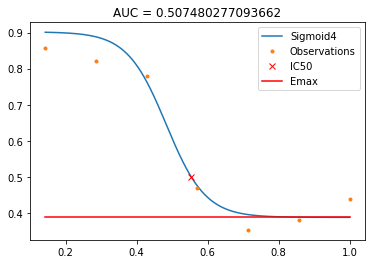

In [20]:
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"In this sections we will extract the summary metrics AUC, Emax and IC50 from the Sigmoid4_parameters functions"
"These metrics are used as the references to compute the error metrics"
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn import metrics
from importlib import reload
import Utils_SummaryMetrics_KLRelevance
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)

"Bear in mind that x starts from 0.142857143 for 7 drug concentrations in GDSC2 dataset"
"but x starts from 0.111111 for the case of 9 drug concentrations in GDSC1 dataset"
"The function Get_IC50_AUC_Emax is implemented in Utils_SummaryMetrics_KLRelevance.py to extract the summary metrics"
x_lin = np.linspace(0.142857143, 1, 1000)
x_real_dose = np.linspace(0.142857143, 1, 7)  #Here is 7 due to using GDSC2 that has 7 doses
Ydose50,Ydose_res,IC50,AUC,Emax = MyUtils.Get_IC50_AUC_Emax(params_4_sig_train,x_lin,x_real_dose)

def my_plot(posy,fig_num,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug):
    plt.figure(fig_num)
    plt.plot(x_lin, Ydose_res[posy])
    plt.plot(x_real_dose, y_train_drug[posy, :], '.')
    plt.plot(IC50[posy], Ydose50[posy], 'rx')
    plt.plot(x_lin, np.ones_like(x_lin)*Emax[posy], 'r') #Plot a horizontal line as Emax
    plt.title(f"AUC = {AUC[posy]}")
    plt.legend(['Sigmoid4','Observations','IC50','Emax'])

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we can visualise the values of the GDSC2 dataset with the fitting of Sigmoid4_parameters function"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
posy = 0   #select the location you want to plot, do not exceed the Ytrain length
my_plot(posy,0,Ydose50,Ydose_res,IC50,AUC,Emax,x_lin,x_real_dose,y_train_drug)

In [21]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Organize summary metrics with proper dimensionality"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
AUC = np.array(AUC)
IC50 = np.array(IC50)
Emax = np.array(Emax)

"Below we select just the columns with std higher than zero"
Name_Features_Melanoma = df_train_No_MolecForm.columns[start_pos_features:]
Xall = X_train_features.copy()
Yall = y_train_drug.copy()

print("Sanity check to the same features Evelyin Provided")
print(df_ANOVA_feat_Names["feature"].values[start_pos_features:]==Name_Features_Melanoma)

AUC_all = AUC[:, None].copy()
IC50_all = IC50[:, None].copy()
Emax_all = Emax[:, None].copy()

print("AUC train size:", AUC_all.shape)
print("IC50 train size:", IC50_all.shape)
print("Emax train size:", Emax_all.shape)
print("X all data size:", Xall.shape)
print("Y all data size:", Yall.shape)

Sanity check to the same features Evelyin Provided
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
AUC train size: (50, 1)
IC50 train size: (50, 1)
Emax train size: (50, 1)
X all data size: (50, 24)
Y all data size: (50, 7)


In [22]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from sklearn.model_selection import KFold, cross_val_score
Ndata = Xall.shape[0]
Xind = np.arange(Ndata)
nsplits = 20 #Ndata
k_fold = KFold(n_splits=nsplits)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

'\n'

In [23]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"MOGP model Training process"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
NegMLL_AllFolds = []
Emax_abs_AllFolds = []
AUC_abs_AllFolds = []
IC50_MSE_AllFolds = []
Med_MSE_AllFolds = []
AllPred_MSE_AllFolds = []
Mean_MSE_AllFolds = []
All_Models = []
Ntasks = Dnorm_cell
list_folds = list(k_fold.split(Xall))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"The for loop below runs K-folds cross-validation process for the MOGP model"
"It is important to highlight that the multiple initializations to select the best model"
"were performed through multiple seeds in a High Performance Computing (HPC) system"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
for Nfold in range(0,nsplits+1):
    model = []
    "The first if below is for the cross-val"
    "Then the else is for using all data to save the model trained over all data"
    Xtrain,Ytrain,Xval,Xval_aux,Yval,Emax_val,IC50_val,AUC_val=MyUtils.ArrangeData_to_CrossVal(Ntasks,Nfold,nsplits,list_folds,Xall,Yall,Emax_all,IC50_all,AUC_all)
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    import GPy
    # os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
    mean_all = np.zeros_like(Yval)
    models_outs = []

    rank = int(config.rank)  # Rank for the MultitaskKernel
    "Below we substract one due to being the label associated to the output"
    Dim = Xtrain.shape[1]-1
    myseed = int(config.which_seed)
    np.random.seed(myseed)
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Product Kernels. Below we use the locations:"
    "Kernel1 accounts for locations 0:11 for Mutation"
    "Kernel2 accounts for locations 11:end for PANCAN"
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    split_dim = 2
    AddKern_loc = [11, Dim]
    mykern = GPy.kern.RBF(AddKern_loc[0], active_dims=list(np.arange(0, AddKern_loc[0])))
    print(list(np.arange(0, AddKern_loc[0])))
    for i in range(1, split_dim):
        mykern = mykern * GPy.kern.RBF(AddKern_loc[i]-AddKern_loc[i-1],active_dims=list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))
        print(list(np.arange(AddKern_loc[i-1], AddKern_loc[i])))

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the kernel hyper-parameters"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    mykern.rbf.lengthscale = float(config.scale)* np.sqrt(Dim) * np.random.rand()
    mykern.rbf.variance.fix()
    for i in range(1,split_dim):
        eval("mykern.rbf_"+str(i)+".lengthscale.setfield(float(config.scale)* np.sqrt(Dim) * np.random.rand(), np.float64)")
        eval("mykern.rbf_" + str(i) + ".variance.fix()")

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Create the coregionalization kernel for the MOGP model and create the MOGPRegression model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    kern = mykern ** GPy.kern.Coregionalize(1, output_dim=Ntasks,rank=rank)
    model = GPy.models.GPRegression(Xtrain, Ytrain, kern)
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Random Initialization of the linear combination coefficients for coregionalization matrix of MOGP"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Init_Ws = float(config.weight) * np.random.randn(Ntasks,rank)
    model.kern.coregion.W = Init_Ws
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "If config.Train is True we will train the models for each Kfold to estimate performance of the crossval seed"
    "On the contrary, if config.Train is False we do not train but load the already best Trained model"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    if config.Train:
        #model.optimize(optimizer='lbfgsb',messages=True,max_iters=int(config.N_iter))
        model.optimize()
    else:
        # Here we load the model bash*:
        m_trained = str(config.bash)
        print("loading model ", m_trained)
    model[:] = np.load('./GDSC2_Codes_ANOVAFeatures/Best_Model_Drug' + config.drug_name + '_MelanomaGDSC2_GPy_ANOVA_ExactMOGP_ProdKern/m_' + m_trained + '.npy')
    
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Make predictions for the Kfold-out"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    m_pred, v_pred = model.predict(Xval, full_cov=False)
    Yval_curve = Yval.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    m_pred_curve = m_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()
    v_pred_curve = v_pred.reshape(Ntasks, Xval_aux.shape[0]).T.copy()

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Here we extract the summary metrics AUC, Emax and IC50 from the MOGP curve predictions"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    from scipy.interpolate import interp1d
    from scipy.interpolate import pchip_interpolate

    x_dose = np.linspace(0.142857143, 1.0, 7)
    x_dose_new = np.linspace(0.142857143, 1.0, 1000)
    Y_pred_interp_all, std_upper_interp_all, std_lower_interp_all, _, Ydose50_pred, IC50_pred, AUC_pred, Emax_pred = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose, x_dose_new=x_dose_new, m_pred_curve=m_pred_curve, v_pred=v_pred)

    Ydose50_pred = np.array(Ydose50_pred)
    IC50_pred = np.array(IC50_pred)[:,None]
    AUC_pred = np.array(AUC_pred)[:, None]
    Emax_pred = np.array(Emax_pred)[:, None]

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    "Compute different error metrics!"
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    Val_NMLL = -np.mean(model.log_predictive_density(Xval, Yval)) #Negative Log Predictive Density (NLPD)
    Emax_abs = np.mean(np.abs(Emax_val - Emax_pred))
    AUC_abs = np.mean(np.abs(AUC_val - AUC_pred))
    IC50_MSE = np.mean((IC50_val - IC50_pred) ** 2)
    MSE_curves = np.mean((m_pred_curve - Yval_curve) ** 2, 1)
    AllPred_MSE = np.mean((m_pred_curve - Yval_curve) ** 2)

    Med_MSE = np.median(MSE_curves)
    Mean_MSE = np.mean(MSE_curves)

    if Nfold < nsplits:
        print(f'\nError Metrics fold {Nfold}:')
        print("\nNegLPD Val", Val_NMLL)
        print("IC50 MSE:", IC50_MSE)
        print("AUC MAE:", AUC_abs)
        print("Emax MAE:", Emax_abs)
        print("Med_MSE:", Med_MSE)
        print("Mean_MSE:", Mean_MSE)
        print("All Predictions MSE:", AllPred_MSE)
        NegMLL_AllFolds.append(Val_NMLL.copy())
        Emax_abs_AllFolds.append(Emax_abs.copy())
        AUC_abs_AllFolds.append(AUC_abs.copy())
        IC50_MSE_AllFolds.append(IC50_MSE.copy())
        Med_MSE_AllFolds.append(Med_MSE.copy())
        Mean_MSE_AllFolds.append(Mean_MSE.copy())
        AllPred_MSE_AllFolds.append(AllPred_MSE.copy())

    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
    """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


[0 1 2] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  547

Error Metrics fold 0:

NegLPD Val -0.38807203254921835
IC50 MSE: 0.022003311142265846
AUC MAE: 0.08588668617449335
Emax MAE: 0.017646079250866753
Med_MSE: 0.021297967471569777
Mean_MSE: 0.024469041911954356
All Predictions MSE: 0.024469041911954353
[3 4 5] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  547

Error Metrics fold 1:

NegLPD Val 0.4075342033653253
IC50 MSE: 0.2604255447062108
AUC MAE: 0.15135358949299252
Emax MAE: 0.27303142259849106
Med_MSE: 0.016505055310887553
Mean_MSE: 0.07508595790789532
All Predictions MSE: 0.07508595790789532
[6 7 8] to Val in IC50
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
loading model  547

Error Metrics fold 2:

NegLPD Val -0.6411825551536446
IC50 MSE: 0.01739031425281438
AUC MAE: 0.05816597662745426
Ema

In [24]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Cross validation performance of the current seed"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
print('Metrics of Seed performance along K-folds (mean +/- std):\n')
print(f'dose response curve MSE: {np.mean(AllPred_MSE_AllFolds)} +/- {np.std(AllPred_MSE_AllFolds)}')
print(f'NegLog Predictive Density: {np.mean(NegMLL_AllFolds)} +/- {np.std(NegMLL_AllFolds)}')
print(f'IC50 MSE: {np.mean(IC50_MSE_AllFolds)} +/- {np.std(IC50_MSE_AllFolds)}')
print(f'AUC MAE: {np.mean(AUC_abs_AllFolds)} +/- {np.std(AUC_abs_AllFolds)}')
print(f'Emax MAE: {np.mean(Emax_abs_AllFolds)} +/- {np.std(Emax_abs_AllFolds)}')

Metrics of Seed performance along K-folds (mean +/- std):

dose response curve MSE: 0.04262563469762966 +/- 0.026971533265613065
NegLog Predictive Density: -0.037702537321738 +/- 0.6146303674969988
IC50 MSE: 0.21801617488422842 +/- 0.20247601770427925
AUC MAE: 0.11443980474314792 +/- 0.050556329672966485
Emax MAE: 0.1832398074259905 +/- 0.07785376480435936


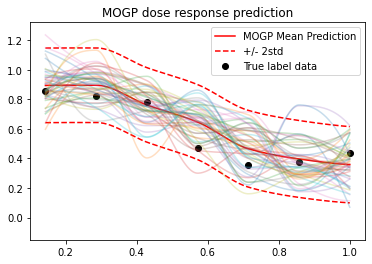

In [25]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Make predictions with the model and plot one of the dose response curves"
"We plot the mean +/- 2std of the MOGP predicitons"
"The multiple coloured functions are samples from predictive posterior distribution"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
N_Samples = 50
Ypred_interp,StdPred_upper_interp,StdPred_lower_interp,Ypred_MOGP_Samples,_,_,_,_ = MyUtils.Predict_Curve_and_SummaryMetrics(x_dose=x_dose,x_dose_new = x_dose_new,model=model,Xval=Xtrain,MOGPsamples=N_Samples)

idx = 0
#for idx in range(20):
plt.figure(idx)
plt.ylim([-0.15,1.32])
plt.plot(x_dose_new,Ypred_interp[idx],'r')
plt.plot(x_dose_new,StdPred_upper_interp[idx],'r--')
plt.plot(x_dose_new,StdPred_lower_interp[idx],'r--')
plt.plot(x_dose, Yall[idx], 'ko')
plt.title('MOGP dose response prediction')
plt.legend(["MOGP Mean Prediction","+/- 2std","_nolegend","True label data"])
for i in range(N_Samples):
    plt.plot(x_dose_new, Ypred_MOGP_Samples[idx][i],alpha=0.25)


In [26]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here We run the KLRelevance algorith over an specific p-th feature"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from importlib import reload
import Utils_SummaryMetrics_KLRelevance as MyUtils
reload(MyUtils)
KLRel = np.zeros((Xtrain.shape[0]//Dnorm_cell,Xtrain.shape[1]-1))
FileName = "Drug"+config.drug_name+"_MelanomaGDSC1_ANOVA_ExactMOGP_m"+m_trained
for pth_feat in range(24):
    relevance = MyUtils.KLRelevance_MOGP_GPy(train_x=Xtrain, model=model, delta=1.0e-6,
                                                       which_p=int(pth_feat), diag=False, Use_Cholesky=True,
                                                       ToSave=False, FileName=FileName)
    KLRel[:,pth_feat] = relevance[:,pth_feat].copy()

Mean_KLRel = np.mean(KLRel,0)[None,:]
Norm_Mean_KLRel = Mean_KLRel/np.max(Mean_KLRel)
Norm_Mean_KLRel_sorted = np.sort(Norm_Mean_KLRel).flatten()[::-1]
ind_sort = np.argsort(Norm_Mean_KLRel)
Names_features_sorted = Name_Features_Melanoma[ind_sort].flatten()[::-1]

Analysing Feature 0 of 24...
Analysing Feature 1 of 24...
Analysing Feature 2 of 24...
Analysing Feature 3 of 24...
Analysing Feature 4 of 24...
Analysing Feature 5 of 24...
Analysing Feature 6 of 24...
Analysing Feature 7 of 24...
Analysing Feature 8 of 24...
Analysing Feature 9 of 24...
Analysing Feature 10 of 24...
Analysing Feature 11 of 24...
Analysing Feature 12 of 24...
Analysing Feature 13 of 24...
Analysing Feature 14 of 24...
Analysing Feature 15 of 24...
Analysing Feature 16 of 24...
Analysing Feature 17 of 24...
Analysing Feature 18 of 24...
Analysing Feature 19 of 24...
Analysing Feature 20 of 24...
Analysing Feature 21 of 24...
Analysing Feature 22 of 24...
Analysing Feature 23 of 24...


In [27]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Here we just update the names of the genomic features and actual drug names"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_new_names={"BRAF_mut":'BRAF mut',
                "ARID1A_mut":"ARID1A mut",
                "EZH2_mut":"EZH2 mut",
                "MECOM_mut":"MECOM mut",
                "PLCB1_mut":"PLCB1 mut",
                "PTEN_mut":"PTEN mut",
                "NRAS_mut":"NRAS mut",
                "ARID2_mut":"ARID2 mut",
                "TP53_mut":"TP53 mut",
                "NF1_mut":"NF1 mut",
                "CDKN2A_mut":"CDKN2A mut",
                "loss.cnaSKCM3":"loss.cna.chr16q23.1",
                "loss.cnaSKCM4..BNC2.CDKN2A.JAK2.PSIP1.":"loss.cna.chr9p24.3",
                "loss.cnaSKCM5..PAX5.":"loss.cna.chr9p13.2",
                "loss.cnaSKCM9":"loss.cna.chr17p13.2",
                "gain.cnaSKCM12..KRAS.":"gain.cna.chr12p12.3",
                "gain.cnaSKCM21..FOXP1.MITF.":"gain.cna.chr3p14.1",
                "loss.cnaSKCM22":"loss.cna.chr10q23.31",
                "loss.cnaSKCM23":"loss.cna.chr10q23.33",
                "loss.cnaSKCM24..loss.cnaSKCM25":"loss.cna.chr10q26.3",
                "loss.cnaSKCM26":"loss.cna.chr14q32.2",
                "loss.cnaSKCM27..CASP1.":"loss.cna.chr11q22.3",
                "loss.cnaSKCM28":"loss.cna.chr11q24.2",
                "loss.cnaSKCM30":"loss.cna.chr2q37.3"}

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"dictionary to map drug_id to drug_name"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
dict_drug_name = {1036:'PLX4720',1061:'SB590885',1373:'Dabrafenib'}

In [28]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a dataframe to plot the KLRelevance ranking"
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Names_feat_sorted_updated = [dict_new_names[Name] for Name in Names_features_sorted] #update features names
df_KLRel_GDSC2 = pd.DataFrame({'dataset':['GDSC2']*Norm_Mean_KLRel_sorted.shape[0],
                               'drug_name':Norm_Mean_KLRel_sorted.shape[0]*[dict_drug_name[int(config.drug_name)]],
                               'drug_id':Norm_Mean_KLRel_sorted.shape[0]*[config.drug_name],'feature_name':Names_feat_sorted_updated,
                               'KL_relevance': Norm_Mean_KLRel_sorted})
df_KLRel_GDSC2

,dataset,drug_name,drug_id,feature_name,KL_relevance
0,GDSC2,PLX4720,1036,BRAF mut,1.000000
1,GDSC2,PLX4720,1036,ARID1A mut,0.733537
2,GDSC2,PLX4720,1036,loss.cna.chr10q23.33,0.699144
3,GDSC2,PLX4720,1036,PLCB1 mut,0.590996
4,GDSC2,PLX4720,1036,loss.cna.chr11q24.2,0.555219
5,GDSC2,PLX4720,1036,loss.cna.chr10q23.31,0.388458
6,GDSC2,PLX4720,1036,loss.cna.chr10q26.3,0.376503
7,GDSC2,PLX4720,1036,MECOM mut,0.369789
8,GDSC2,PLX4720,1036,EZH2 mut,0.365483
9,GDSC2,PLX4720,1036,loss.cna.chr9p24.3,0.306805


In [29]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Concatenate KLRelevance for GDSC1 and GDSC2 to plot the image that appears in the manuscript" 
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_KLRel_GDSC1_and_GDSC2 = pd.concat([df_KLRel_GDSC1, df_KLRel_GDSC2])
df_KLRel_GDSC1_and_GDSC2

,dataset,drug_name,drug_id,feature_name,KL_relevance
0,GDSC1,PLX4720,1036,loss.cna.chr10q23.33,1.000000
1,GDSC1,PLX4720,1036,loss.cna.chr10q23.31,0.832888
2,GDSC1,PLX4720,1036,EZH2 mut,0.742242
3,GDSC1,PLX4720,1036,PTEN mut,0.678015
4,GDSC1,PLX4720,1036,loss.cna.chr11q24.2,0.639183
5,GDSC1,PLX4720,1036,BRAF mut,0.632634
6,GDSC1,PLX4720,1036,loss.cna.chr10q26.3,0.596045
7,GDSC1,PLX4720,1036,loss.cna.chr16q23.1,0.558467
8,GDSC1,PLX4720,1036,gain.cna.chr3p14.1,0.500565
9,GDSC1,PLX4720,1036,MECOM mut,0.471784


In [35]:
df_KLRel_GDSC1_and_GDSC2.to_csv('ANOVA_KL_relevance_PLX.csv')

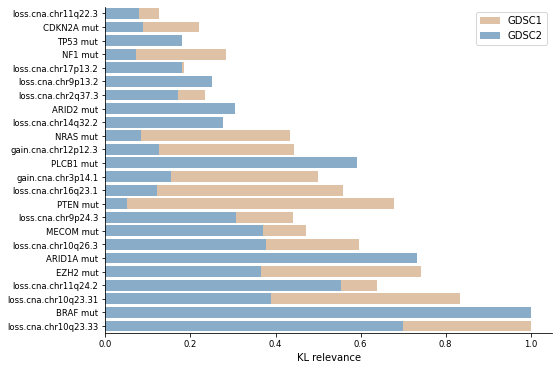

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns# Assuming you have a DataFrame named ‘ANOVA_KLrelevance_PLX’ with the data# Rearrange the feature_name column based on KL_relevance mean
ANOVA_KLrelevance_PLX = pd.read_csv('ANOVA_KL_relevance_PLX.csv')
ANOVA_KLrelevance_PLX['feature_name'] = pd.Categorical(ANOVA_KLrelevance_PLX['feature_name'],
                                                       categories=ANOVA_KLrelevance_PLX.groupby('feature_name')['KL_relevance'].mean().sort_values(ascending=False).index,
                                                       ordered=True)# Create the plot
plt.figure(figsize=(8, 6))
sns.barplot(data=ANOVA_KLrelevance_PLX,
            x='KL_relevance',
            y='feature_name',
            hue='dataset',
            palette=['#E8C09C', '#7FAFD2'],
            dodge=False)
plt.xlabel('KL relevance')
plt.ylabel('')
plt.title('')
plt.xticks(size=8.5)
plt.yticks(size=8.5)
plt.gca().invert_yaxis()
plt.legend(loc='upper right', title=None)
sns.despine()
plt.show()